## Question 7 - Is playing a check a symbol of being on the offensive or on the defensive?

This question is an addendum to Question 4, and was not in my original analysis. These results were added on after my presentation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Data Preprocessing and Loading

For this question, we will interpret being on the offensive as having an advantage. Most players would agree that it feels better to be on the offensive than on the defensive, so we can use this to gauge how a player is feeling at a given board state.

We will load in the following columns:
- game_id,
- is_check,
- board evaluation

For our subquestions, we will also read in
- player elo,
- the time control, and
- remaining clock time.

We perform the same preprocessing step as in Question 4 of discarding the first and last game_id in each chunk.

In [2]:
# these variables we can change
columns_to_load = ['game_id', 'termination', 'is_check', 'cp_rel', 'move_ply', 'white_elo', 'black_elo', 'time_control', 'num_ply', 'clock']
dtype = {'game_id':str, 'termination':str, 'is_check':bool, 'cp_rel':'float64', 'move_ply':int, 'white_elo':int, 'black_elo':int, 'time_control':str, 'num_ply':int, 'clock':'Int64'}

# a helper function used to:
# 1. drop the first and last game id in each chunk
# 2. drop the games that were not won by checkmate or timeout
def read_chunk(df):
  # step 1
  df = df[~df['game_id'].isin([df['game_id'].iloc[0], df['game_id'].iloc[-1]])]
  # step 2
  df = df[df['termination'].isin(['Normal', 'Time forfeit'])]
  # step 3
  df = df.drop(columns=['termination'])
  # return
  return df

In [3]:
url = "https://csslab.cs.toronto.edu/data/chess/monthly/lichess_db_standard_rated_2019-01.csv.bz2"

max_chunks = 150
chunksize = 1e5
chunk_counter = 0
filtered_chunks = []

start_time = time.time()
for chunk in pd.read_csv(url, compression='bz2', usecols = columns_to_load, chunksize=chunksize, dtype=dtype):
    filtered_chunks.append(read_chunk(chunk))
    chunk_counter += 1

    if chunk_counter >= max_chunks:
        break

df = pd.concat(filtered_chunks, ignore_index=True)
df_original = df.copy() # store a copy in case we want to revert the analysis to this checkpoint at any time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to read the first {chunk_counter} chunks of size {chunksize:.2e}: {elapsed_time:.2f} seconds")

print(df.shape)
df.head()

Time taken to read the first 150 chunks of size 1.00e+05: 341.49 seconds
(14988143, 9)


,game_id,white_elo,black_elo,time_control,num_ply,move_ply,cp_rel,clock,is_check
0,WagNiFfQ,1826,1826,300+0,107,0,0.10,300,False
1,WagNiFfQ,1826,1826,300+0,107,1,-0.12,150,False
2,WagNiFfQ,1826,1826,300+0,107,2,0.18,300,False
3,WagNiFfQ,1826,1826,300+0,107,3,-0.00,149,False
4,WagNiFfQ,1826,1826,300+0,107,4,0.13,300,False


In [4]:
df = df_original.copy()

There are different ways to gauge how a player is feeling at a particular point in the game. One is the engine's evaluation of the board, which, while not a perfect representation of what the players might be thinking, could be used to estimate this. Another is whether the player is under any time pressure, as well as how long the game has been going for, which might lead to fatigue. We explore each of these possibilities as a separate subquestion.

### Question 7.1.1 - How is the relative board evaluation distributed among moves that are checks?

For this question, we separate the dataset into moves that are checks and moves that are not checks, and visualize the distribution of the board evaluation in both.

One challenge in quantifying the board evluation is the set of positions where mate is inevitable. For example, if the board is mate in 1 for Black, then the evaluation is negative infinity. Of course, we would not be able to plot negative infinity. Thus, we should pick a cutoff value $c$ for which all evaluations greater than $c$, including positive infinity, get rounded down to $c$, while all evluations less than $-c$, including negative infinity, get rounded up to $-c$.

We pick $c = 40$, the sum of the material difference if one player has only their King while the other has everything else, counting Bishops as $3.5$. This decision also is based on the underlying assumption that players playing optimally would be able to convert any position in which they are leading by over $40$ points into a win.

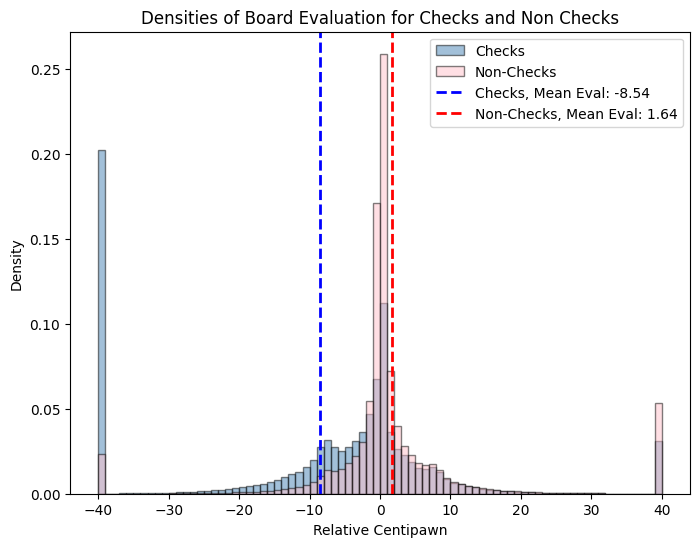

In [5]:
cutoff = 40
bins = 80

df['cp_rel'] = df['cp_rel'].apply(lambda x: cutoff if x > cutoff else (-1 * cutoff if x < -1 * cutoff else x))
# since we left a copy of the original dataframe, we can modify the current df without worry

df_check_true = df[df['is_check'] == True]['cp_rel']
df_check_false = df[df['is_check'] == False]['cp_rel']

mean_true = df_check_true.mean()
mean_false = df_check_false.mean()

plt.figure(figsize=(8,6))

plt.hist(df_check_true, alpha=0.5, label="Checks", bins=bins, density=True, edgecolor='black', color='steelblue')
plt.hist(df_check_false, alpha=0.5, label="Non-Checks", bins=bins, density=True, edgecolor='black', color='pink')

plt.axvline(mean_true, color='blue', linestyle='dashed', linewidth=2, label=f'Checks, Mean Eval: {mean_true:.2f}')
plt.axvline(mean_false, color='red', linestyle='dashed', linewidth=2, label=f'Non-Checks, Mean Eval: {mean_false:.2f}')

plt.xlabel('Relative Centipawn')
plt.ylabel('Density')
plt.legend()
plt.title("Densities of Board Evaluation for Checks and Non Checks")
plt.show()

This comparison shows that on average, moves that are checks are made more often when the player is not in the advantage.

Let's also see what percentage of the time the position had a forced mate that loses the player making the check.

In [6]:
negative_infinity_count = np.sum(np.isneginf(df_original['cp_rel']))
total_rows = len(df_original)
percentage_negative_infinity = (negative_infinity_count / total_rows) * 100
print(f"Percentage of rows with negative infinity in 'cp_rel': {percentage_negative_infinity:.2f}%")

Percentage of rows with negative infinity in 'cp_rel': 3.19%


One area of concern is that the moves are not correlated. For example, if a move is a check, the chance that the next move played by the other player is also a check goes down, while the chance that the next move played by the same player might go up. To mitigate this effect, let's take the average evaluation for each player of the moves they made that were checks and the moves they made that weren't, and plot the distributions of each across games.

In [7]:
df['move_ply_parity'] = df['move_ply'] % 2

frequency = df.groupby(['game_id', 'is_check', 'move_ply_parity']).size().reset_index(name='frequency')

game_id_values = df['game_id'].unique()
is_check_values = [True, False]
move_ply_parity_values = [0, 1]

full_combinations = pd.MultiIndex.from_product(
    [game_id_values, is_check_values, move_ply_parity_values],
    names=['game_id', 'is_check', 'move_ply_parity']
).to_frame(index=False)

df_check_avg = pd.merge(full_combinations, frequency, on=['game_id', 'is_check', 'move_ply_parity'], how='left')

grouped_df = df.groupby(['game_id', 'is_check', 'move_ply_parity'], as_index=False)['cp_rel'].mean()
df_check_avg = pd.merge(df_check_avg, grouped_df, how='left', on=['game_id', 'is_check', 'move_ply_parity']).fillna(np.nan)

df_check_avg['frequency'] = df_check_avg['frequency'].fillna(0)
df_check_avg['move_ply_type'] = df_check_avg['move_ply_parity'].map({0: 'white', 1: 'black'})
df_check_avg = df_check_avg.drop(columns=['move_ply_parity'])

print(df_check_avg)

         game_id  is_check  frequency     cp_rel move_ply_type
0       WagNiFfQ      True        6.0 -27.576667         white
1       WagNiFfQ      True        2.0   9.095000         black
2       WagNiFfQ     False       48.0 -17.887917         white
3       WagNiFfQ     False       51.0  20.029412         black
4       MVfPHhJJ      True        0.0        NaN         white
...          ...       ...        ...        ...           ...
947407  0QZGMinR     False       23.0   0.169565         black
947408  1pO73Gku      True        2.0 -40.000000         white
947409  1pO73Gku      True        0.0        NaN         black
947410  1pO73Gku     False       22.0  -0.003182         white
947411  1pO73Gku     False       24.0   5.350417         black

[947412 rows x 5 columns]


This dataframe has 4 rows for each game, one for each combination of player and whether it was a move or not. One way to compare the moves that are checks and moves that are not is to plot the distribution of the cp_rel values for the rows for each value of is_check.

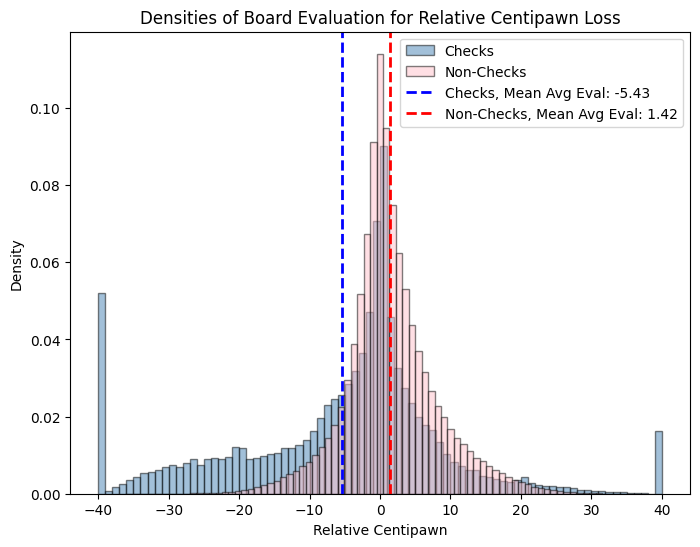

In [8]:
df_check_true = df_check_avg[df_check_avg['is_check'] == True]['cp_rel']
df_check_false = df_check_avg[df_check_avg['is_check'] == False]['cp_rel']

mean_true = df_check_true.mean()
mean_false = df_check_false.mean()

plt.figure(figsize=(8,6))

plt.hist(df_check_true, alpha=0.5, label="Checks", bins=bins, density=True, edgecolor='black', color='steelblue')
plt.hist(df_check_false, alpha=0.5, label="Non-Checks", bins=bins, density=True, edgecolor='black', color='pink')

plt.axvline(mean_true, color='blue', linestyle='dashed', linewidth=2, label=f'Checks, Mean Avg Eval: {mean_true:.2f}')
plt.axvline(mean_false, color='red', linestyle='dashed', linewidth=2, label=f'Non-Checks, Mean Avg Eval: {mean_false:.2f}')

plt.xlabel('Relative Centipawn')
plt.ylabel('Density')
plt.legend()
plt.title("Densities of Board Evaluation for Relative Centipawn Loss")

plt.show()

Each data point is the mean centipawn evaluation across all moves. It is interesting that the non-checks somewhat normally distributed.



Let's also filter by player, white and black.

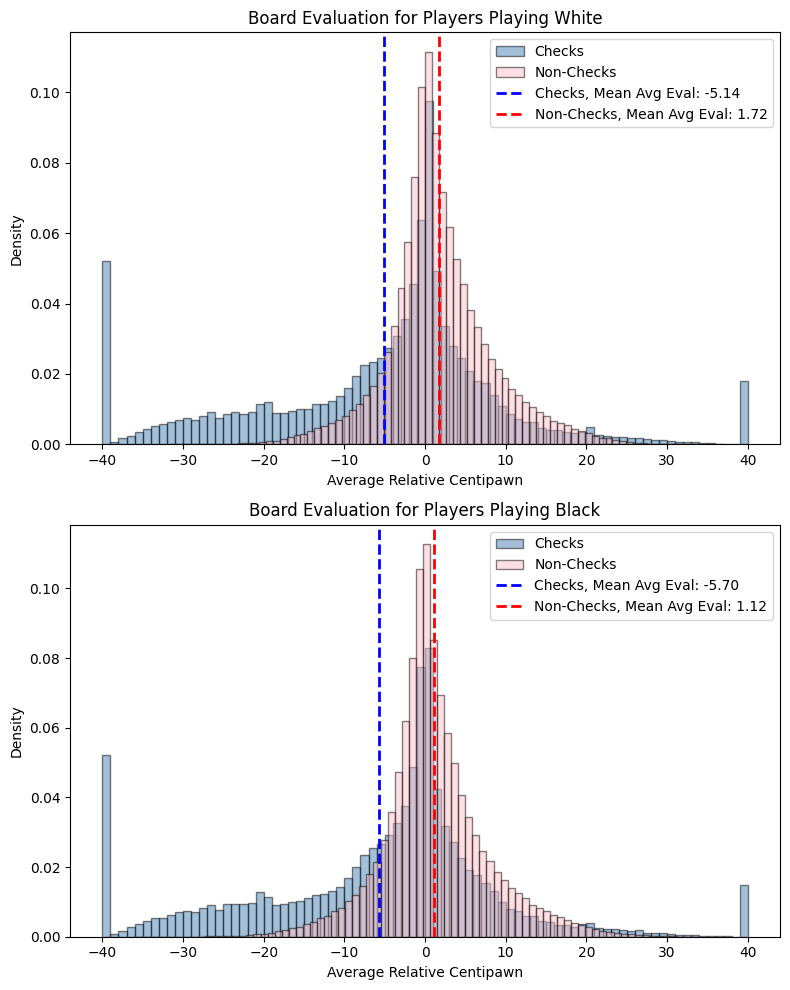

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

df_check_true = df_check_avg[(df_check_avg['is_check'] == True) & (df_check_avg['move_ply_type'] == 'white')]['cp_rel']
df_check_false = df_check_avg[(df_check_avg['is_check'] == False) & (df_check_avg['move_ply_type'] == 'white')]['cp_rel']
mean_true = df_check_true.mean()
mean_false = df_check_false.mean()

ax[0].hist(df_check_true, alpha=0.5, label="Checks", bins=bins, density=True, edgecolor='black', color='steelblue')
ax[0].hist(df_check_false, alpha=0.5, label="Non-Checks", bins=bins, density=True, edgecolor='black', color='pink')
ax[0].axvline(mean_true, color='blue', linestyle='dashed', linewidth=2, label=f'Checks, Mean Avg Eval: {mean_true:.2f}')
ax[0].axvline(mean_false, color='red', linestyle='dashed', linewidth=2, label=f'Non-Checks, Mean Avg Eval: {mean_false:.2f}')
ax[0].set_xlabel('Average Relative Centipawn')
ax[0].set_ylabel('Density')
ax[0].set_title("Board Evaluation for Players Playing White")
ax[0].legend()

df_check_true = df_check_avg[(df_check_avg['is_check'] == True) & (df_check_avg['move_ply_type'] == 'black')]['cp_rel']
df_check_false = df_check_avg[(df_check_avg['is_check'] == False) & (df_check_avg['move_ply_type'] == 'black')]['cp_rel']
mean_true = df_check_true.mean()
mean_false = df_check_false.mean()

ax[1].hist(df_check_true, alpha=0.5, label="Checks", bins=bins, density=True, edgecolor='black', color='steelblue')
ax[1].hist(df_check_false, alpha=0.5, label="Non-Checks", bins=bins, density=True, edgecolor='black', color='pink')
ax[1].axvline(mean_true, color='blue', linestyle='dashed', linewidth=2, label=f'Checks, Mean Avg Eval: {mean_true:.2f}')
ax[1].axvline(mean_false, color='red', linestyle='dashed', linewidth=2, label=f'Non-Checks, Mean Avg Eval: {mean_false:.2f}')
ax[1].set_xlabel('Average Relative Centipawn')
ax[1].set_ylabel('Density')
ax[1].set_title("Board Evaluation for Players Playing Black")
ax[1].legend()

plt.tight_layout()
plt.show()

Anyone else find it interesting that the means are lower for Black than for White?

### Question 7.1.2 - How often is a check followed up by another check (by the same player)?

For example, if ply 5 was a check, what is the likelihood that ply 7 was also a check? Note that ply 6 would be played by the other player.

In [10]:
df_next_move = df[['game_id', 'move_ply', 'is_check']]
df_next_move.loc[:, ['is_next_check']] = df_next_move.groupby('game_id')['is_check'].shift(-1)
df_next_move.loc[:, ['is_next_next_check']] = df_next_move.groupby('game_id')['is_check'].shift(-2)

df_next_move.iloc[94:108]

,game_id,move_ply,is_check,is_next_check,is_next_next_check
94,WagNiFfQ,94,False,False,False
95,WagNiFfQ,95,False,False,False
96,WagNiFfQ,96,False,False,True
97,WagNiFfQ,97,False,True,False
98,WagNiFfQ,98,True,False,False
99,WagNiFfQ,99,False,False,False
100,WagNiFfQ,100,False,False,False
101,WagNiFfQ,101,False,False,False
102,WagNiFfQ,102,False,False,False
103,WagNiFfQ,103,False,False,False


Now we can count the frequencies.

In [11]:
df_next_move = df_next_move.loc[df_next_move['is_next_check'].notna()] # this removes moves that are checkmate

checks = len(df_next_move[df_next_move['is_check'] == True])
both_checks = len(df_next_move[(df_next_move['is_check'] == True) & (df_next_move['is_next_check'] == True)])
chain_checks = len(df_next_move[(df_next_move['is_check'] == True) & (df_next_move['is_next_next_check'] == True)])

both_prop = both_checks / checks
chain_prop = chain_checks / checks

print(f"Number of Non-Game-Ending Checks: {checks}")
print(f"Number of Checks Followed by an Opposing Check: {both_checks}")
print(f"Proportion: {both_prop:.4f}")
print(f"Number of Checks Followed by a Chained Check: {chain_checks}")
print(f"Proportion: {chain_prop:.4f}")

Number of Non-Game-Ending Checks: 1029029
Number of Checks Followed by an Opposing Check: 5662
Proportion: 0.0055
Number of Checks Followed by a Chained Check: 304533
Proportion: 0.2959


### Question 7.2 - How is the number of checks in a game correlated with the number of plies in the game?

In [12]:
num_check = df[df['is_check'] == True].groupby('game_id').size().reset_index(name='num_check')

max_move_ply = df.groupby('game_id')['move_ply'].max().reset_index(name='max_move_ply')
max_move_ply['max_move_ply'] += 1 # plies are 0-indexed
df_plies = pd.merge(num_check, max_move_ply, on='game_id')
df_plies['prop_check'] = df_plies['num_check'] / df_plies['max_move_ply']

print(df_plies)

         game_id  num_check  max_move_ply  prop_check
0       002IieJZ          9            84    0.107143
1       002YNeTp          1            48    0.020833
2       003IXOYM          1            38    0.026316
3       003YVmr4          3            75    0.040000
4       004BLY0J          3            75    0.040000
...          ...        ...           ...         ...
209146  zzrCUIFm          7            60    0.116667
209147  zzryusi5          5            96    0.052083
209148  zzvIteVj          1            38    0.026316
209149  zzxX3wPm         13            78    0.166667
209150  zzzd2wa8         13            86    0.151163

[209151 rows x 4 columns]


In [13]:
df_plies = df_plies[(df_plies['num_check'] <= 100) & (df_plies['max_move_ply'] <= 300)]
correlation = df_plies['max_move_ply'].corr(df_plies['num_check'])
print(f"Correlation between # of Checks and # of Plies, Outliers Removed: {correlation:.2f}")

Correlation between # of Checks and # of Plies, Outliers Removed: 0.63


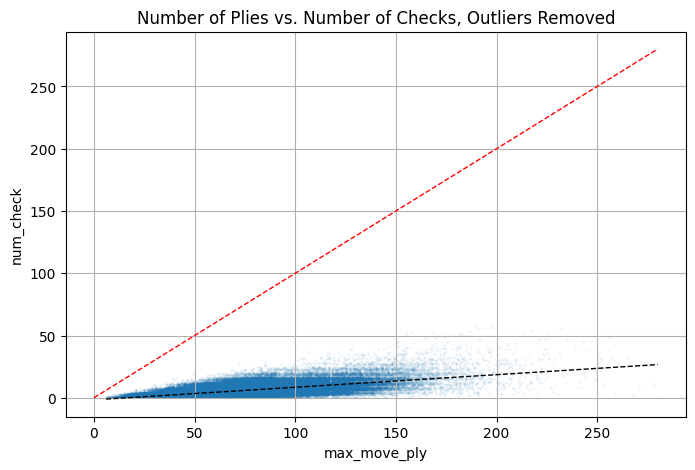

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(df_plies['max_move_ply'], df_plies['num_check'], s=1, alpha=0.05)
plt.title('Number of Plies vs. Number of Checks, Outliers Removed')
plt.xlabel('max_move_ply')
plt.ylabel('num_check')

max_val = max(df_plies['max_move_ply'].max(), df_plies['num_check'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=1)

slope, intercept = np.polyfit(df_plies['max_move_ply'], df_plies['num_check'], 1)
line_x = np.linspace(df_plies['max_move_ply'].min(), df_plies['max_move_ply'].max(), 100)
line_y = slope * line_x + intercept

plt.plot(line_x, line_y, color='black', linestyle='--', lw=1, label='Line of Best Fit')

plt.grid(True)
plt.show()

In [15]:
df_plies = df_plies[(df_plies['num_check'] <= 100) & (df_plies['max_move_ply'] <= 200)]
correlation = df_plies['max_move_ply'].corr(df_plies['prop_check'])
print(f"Correlation between # of Checks and Check Proportion, Outliers Removed: {correlation:.2f}")

Correlation between # of Checks and Check Proportion, Outliers Removed: 0.14


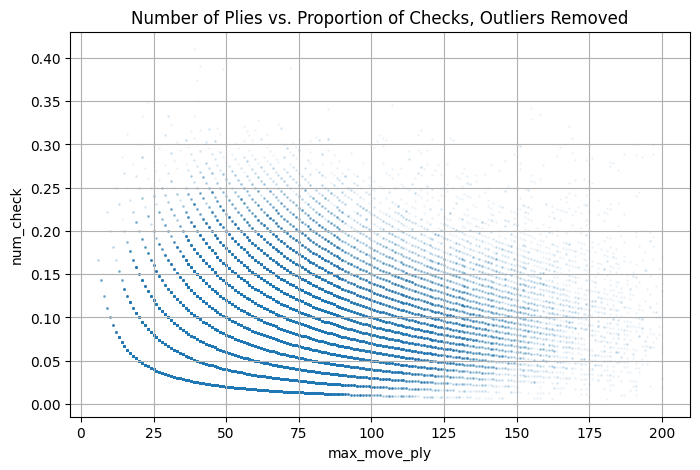

In [16]:
plt.figure(figsize=(8,5))
plt.scatter(df_plies['max_move_ply'], df_plies['prop_check'], s=1, alpha=0.05)
plt.title('Number of Plies vs. Proportion of Checks, Outliers Removed')
plt.xlabel('max_move_ply')
plt.ylabel('num_check')

plt.grid(True)
plt.show()

How aesthetic! The curves are due to the low number of possible numbers of checks that could happen. For example, a game that lasts only $20$ plies would have only about $10$ different values that could represent the number of checks. Each of these curves represents a different number of checks in the game, so this graph is not surprising upon further analysis.

### Question 7.3 - Do players play more checks when they are under time pressure?

For this question, we look only at the 10+0 games, so that the games that we compare have the same starting position. We want to compare how the percentage of moves that are checks differ at varying times in the game. Thus, we bin the moves based on how much time is left on the clock.

In [17]:
df_10 = df[df['time_control'] == '600+0'][['game_id', 'clock', 'is_check']]

df_10['clock'] = df_10.groupby('game_id')['clock'].shift(2)
df_10.loc[df_10.groupby('game_id').head(2).index, 'clock'] = 600
df_10.rename(columns={'clock': 'clock_start_time'}, inplace=True)

bins = list(range(0, 601, 30))
bin_labels = [f'{i} to {i+30}' for i in range(0, 600, 30)]

df_10['clock_bin'] = pd.cut(df_10['clock_start_time'], bins=bins, labels=bin_labels, right=False)
df_10.head()

,game_id,clock_start_time,is_check,clock_bin
684,rMi874dQ,600,False,NaN
685,rMi874dQ,600,False,NaN
686,rMi874dQ,600,False,NaN
687,rMi874dQ,600,False,NaN
688,rMi874dQ,599,False,570 to 600


I think it is fine to leave the NAs there since these will only be present for the moves that had 600 seconds on the clock to start. These will usually be in the beginning of the game, in which case checks likely won't be possible anyway.

In [18]:
bin_stats = df_10.groupby('clock_bin', observed=True).agg(
    num_rows=('clock_start_time', 'size'),
    check_true_percentage=('is_check', lambda x: (x.sum() / len(x)) * 100)
)

bin_stats

,num_rows,check_true_percentage
clock_bin,,
0 to 30,44635,16.119637
30 to 60,50785,15.404155
60 to 90,41408,15.197546
90 to 120,46221,14.441488
120 to 150,51603,14.332500
150 to 180,57050,14.241893
180 to 210,64193,13.423582
210 to 240,72948,13.212151
240 to 270,83273,12.330527


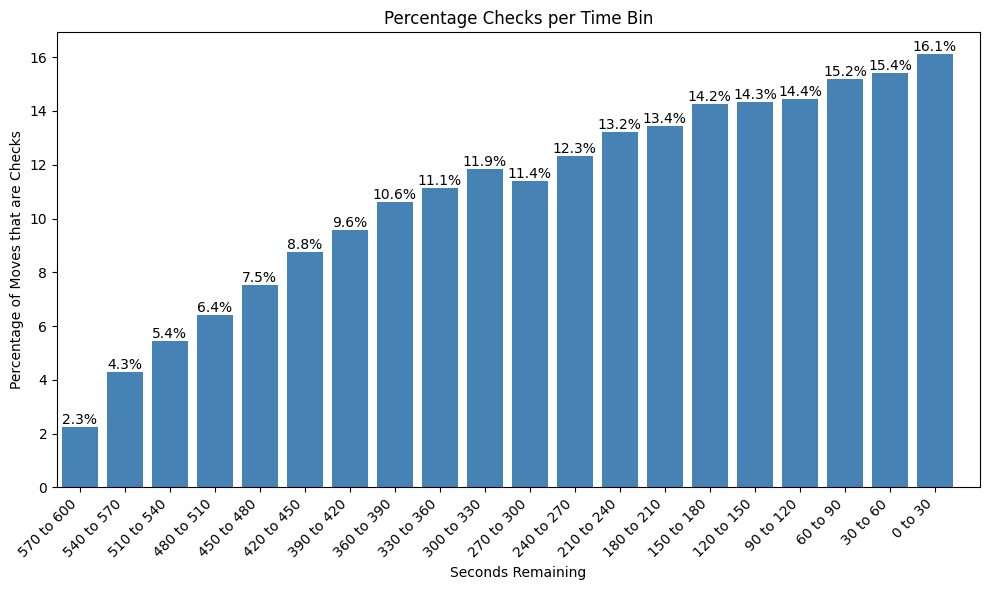

In [19]:
plt.figure(figsize=(10, 6))

bin_stats_reversed = bin_stats[::-1]
bars = plt.bar(bin_stats_reversed.index, bin_stats_reversed['check_true_percentage'], color='steelblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Seconds Remaining')
plt.ylabel('Percentage of Moves that are Checks')
plt.title('Percentage Checks per Time Bin')
plt.xticks(rotation=45, ha='right')
plt.xlim((-0.5, len(bin_stats_reversed-0.5)))

plt.tight_layout()
plt.show()

This result is mostly unsurprising, but still good to verify. However, what if we filter for only games that lasted until the final $30$ seconds?

In [20]:
df_10 = df[df['time_control'] == '600+0'][['game_id', 'clock', 'is_check']]
df_10 = df_10.groupby('game_id').filter(lambda x: (x['clock'] < 30).any())

df_10['clock'] = df_10.groupby('game_id')['clock'].shift(2)
df_10.loc[df_10.groupby('game_id').head(2).index, 'clock'] = 600
df_10.rename(columns={'clock': 'clock_start_time'}, inplace=True)

df_10['clock_bin'] = pd.cut(df_10['clock_start_time'], bins=bins, labels=bin_labels, right=False)
print(df_10.shape)
df_10.head()

(566882, 4)


,game_id,clock_start_time,is_check,clock_bin
6079,xWKe2kZ8,600,False,NaN
6080,xWKe2kZ8,600,False,NaN
6081,xWKe2kZ8,600,False,NaN
6082,xWKe2kZ8,600,False,NaN
6083,xWKe2kZ8,600,False,NaN


In [21]:
bin_stats = df_10.groupby('clock_bin', observed=True).agg(
    num_rows=('clock_start_time', 'size'),
    check_true_percentage=('is_check', lambda x: (x.sum() / len(x)) * 100)
)

bin_stats

,num_rows,check_true_percentage
clock_bin,,
0 to 30,44635,16.119637
30 to 60,41385,14.824212
60 to 90,25719,13.896341
90 to 120,23846,13.201375
120 to 150,22825,13.064622
150 to 180,22199,12.586153
180 to 210,21917,12.109322
210 to 240,21757,11.701981
240 to 270,22078,10.530845


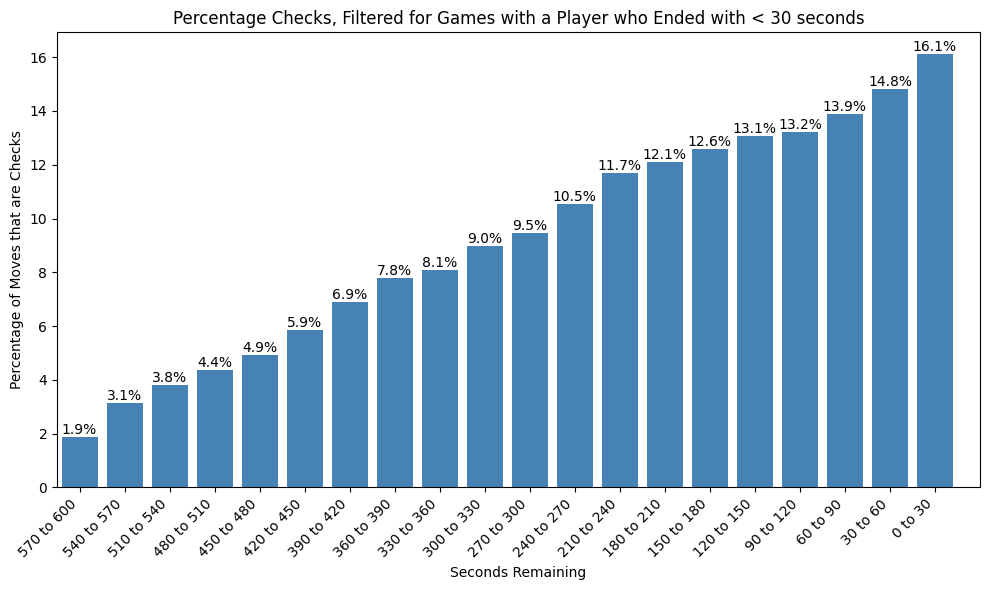

In [22]:
plt.figure(figsize=(10, 6))

bin_stats_reversed = bin_stats[::-1]
bars = plt.bar(bin_stats_reversed.index, bin_stats_reversed['check_true_percentage'], color='steelblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Seconds Remaining')
plt.ylabel('Percentage of Moves that are Checks')
plt.title('Percentage Checks, Filtered for Games with a Player who Ended with < 30 seconds')
plt.xticks(rotation=45, ha='right')
plt.xlim((-0.5, len(bin_stats_reversed-0.5)))

plt.tight_layout()
plt.show()

A much more linear trend, but no big difference.

### Question 7.4 - How is the number of checks correlated with the elos and elo difference between the two players?

Let's make three visualizations for this subquestion.
- First, let's plot the number of checks that white makes in a game against the number of checks that black makes.
- Second, let's plot the average elo of the two players against the total number of checks made between the two players.
- Third, let's plot the difference between the two players' elo, with a positive difference indicating white has a higher elo and a negative difference indicating black has a higher elo, against the difference between the number of checks.

In [23]:
df_elo = df.groupby('game_id').agg(
    checks_total = ('is_check', lambda x: (x == True).sum()),
    checks_white = ('is_check', lambda x: ((x == True) & (df.loc[x.index, 'move_ply_parity'] == 0)).sum()),
    checks_black = ('is_check', lambda x: ((x == True) & (df.loc[x.index, 'move_ply_parity'] == 1)).sum()),
    white_elo=('white_elo', 'first'),
    black_elo=('black_elo', 'first')
).reset_index()

df_elo['average_elo'] = (df_elo['white_elo'] + df_elo['black_elo']) / 2
df_elo['elo_difference'] = df_elo['white_elo'] - df_elo['black_elo']

print(df_elo.shape)
df_elo.head()

(236853, 8)


,game_id,checks_total,checks_white,checks_black,white_elo,black_elo,average_elo,elo_difference
0,002IieJZ,9,6,3,917,1015,966.0,-98
1,002YNeTp,1,1,0,1648,1642,1645.0,6
2,003IXOYM,1,1,0,2521,2439,2480.0,82
3,003YVmr4,3,1,2,1260,1299,1279.5,-39
4,004BLY0J,3,3,0,1105,1259,1182.0,-154


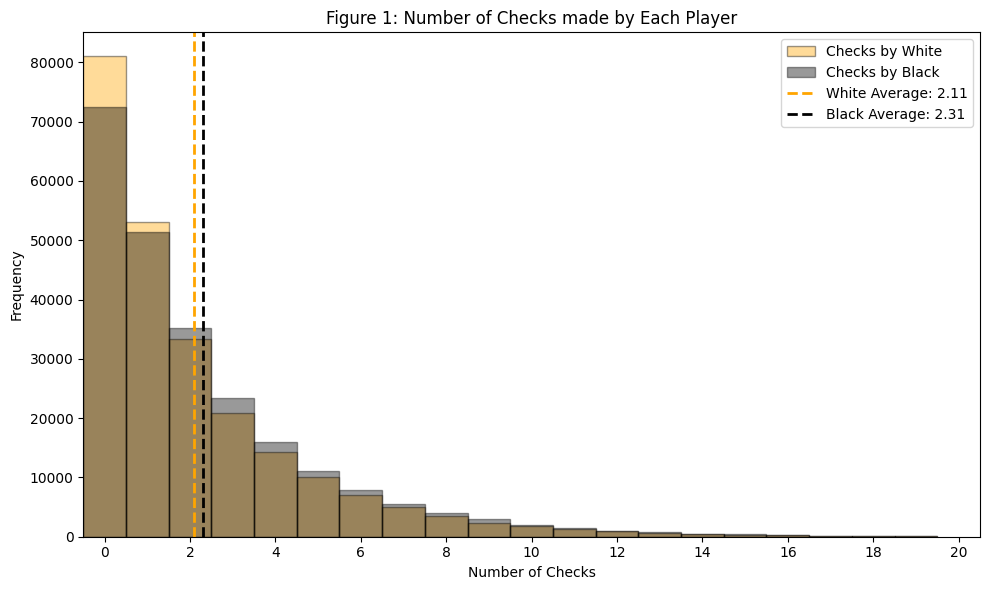

In [24]:
plt.figure(figsize=(10, 6))

cutoff = np.percentile(np.concatenate([df_elo['checks_white'], df_elo['checks_black']]), 99.9)
bins = np.arange(0, cutoff)

avg_white = df_elo['checks_white'].mean()
avg_black = df_elo['checks_black'].mean()

plt.hist(df_elo['checks_white'], bins=bins, alpha=0.4, label='Checks by White', color='orange', edgecolor='k', align='left')
plt.hist(df_elo['checks_black'], bins=bins, alpha=0.4, label='Checks by Black', color='black', edgecolor='k', align='left')

plt.axvline(avg_white, color='orange', linestyle='--', linewidth=2, label=f'White Average: {avg_white:.2f}')
plt.axvline(avg_black, color='black', linestyle='--', linewidth=2, label=f'Black Average: {avg_black:.2f}')

plt.xlabel('Number of Checks')
plt.ylabel('Frequency')
plt.title('Figure 1: Number of Checks made by Each Player')
plt.xlim(0, cutoff)
plt.xticks(np.arange(0, cutoff, 2))
plt.xlim([-0.5,cutoff-0.5])

plt.legend()
plt.tight_layout()
plt.show()

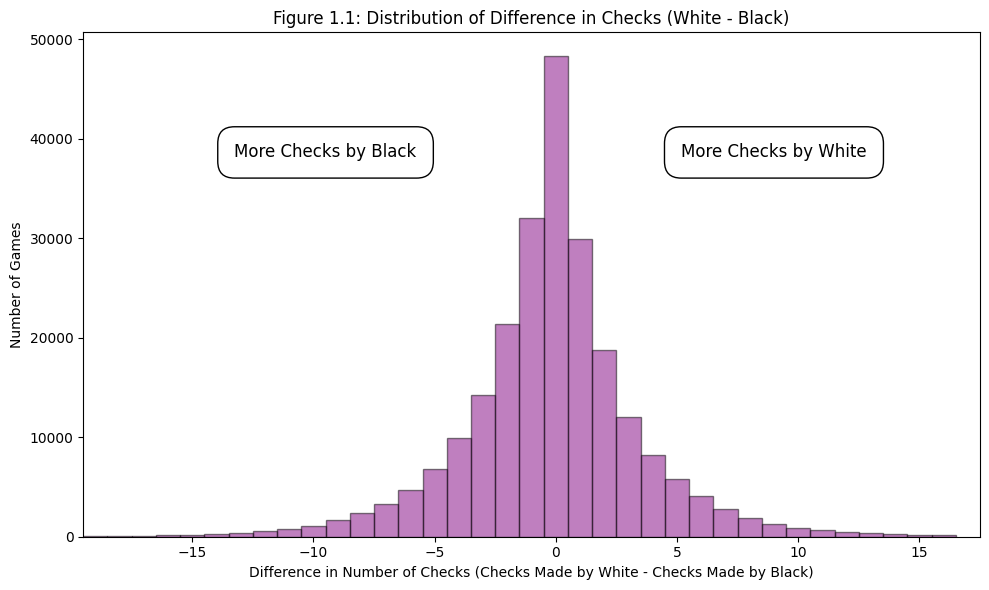

In [25]:
df_elo['check_diff'] = df_elo['checks_white'] - df_elo['checks_black']
lower_percentile = np.percentile(df_elo['check_diff'], 0.1)
upper_percentile = np.percentile(df_elo['check_diff'], 99.9)
bins = np.arange(lower_percentile, upper_percentile, 1)

plt.figure(figsize=(10, 6))
heights, _, _ = plt.hist(df_elo['check_diff'], bins=bins, alpha=0.5, color='purple', edgecolor='black', align='left', zorder=2)

plt.xlabel('Difference in Number of Checks (Checks Made by White - Checks Made by Black)')
plt.ylabel('Number of Games')
plt.title('Figure 1.1: Distribution of Difference in Checks (White - Black)')
plt.xticks()
plt.xlim(lower_percentile-0.5, upper_percentile-0.5)

plt.text(lower_percentile * 0.5, max(heights)*0.8, 'More Checks by Black', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.text(upper_percentile * 0.5, max(heights)*0.8, 'More Checks by White', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.tight_layout()
plt.show()

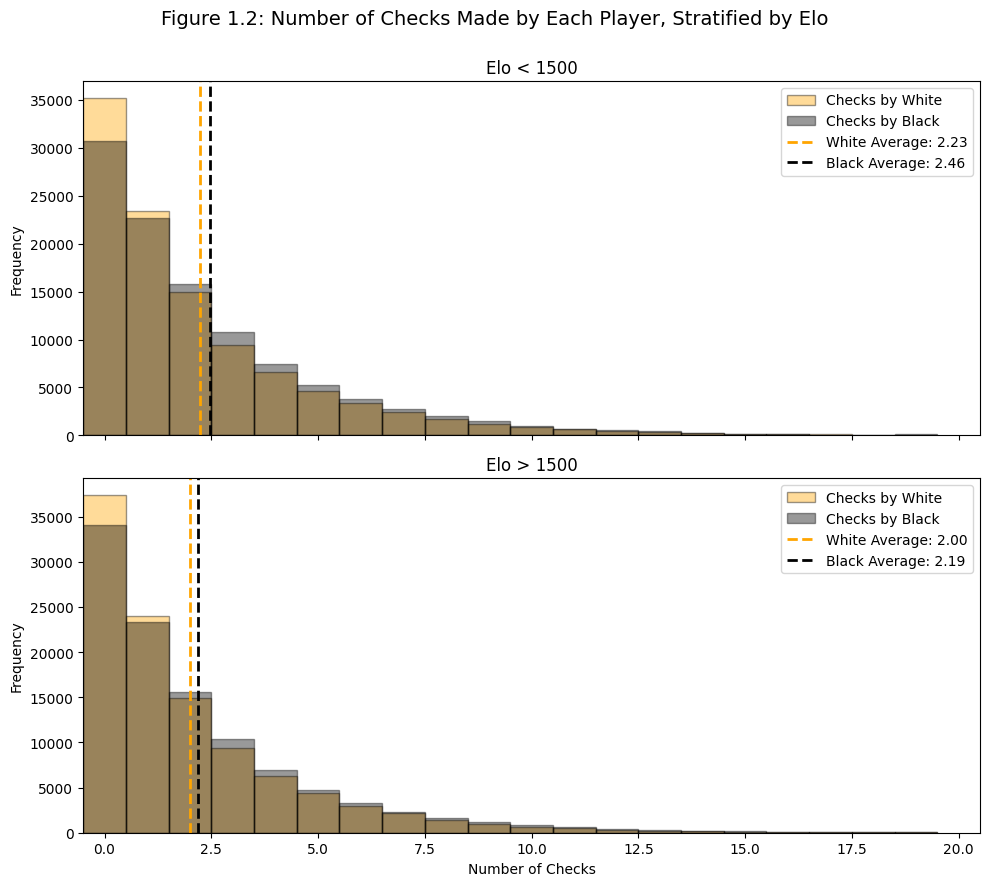

In [26]:
df_low_elo = df_elo[(df_elo['white_elo'] < 1500) & (df_elo['black_elo'] < 1500)]
df_high_elo = df_elo[(df_elo['white_elo'] > 1500) & (df_elo['black_elo'] > 1500)]

cutoff = np.percentile(np.concatenate([df_elo['checks_white'], df_elo['checks_black']]), 99.9)
bins = np.arange(0, cutoff)

avg_white_low = df_low_elo['checks_white'].mean()
avg_black_low = df_low_elo['checks_black'].mean()
avg_white_high = df_high_elo['checks_white'].mean()
avg_black_high = df_high_elo['checks_black'].mean()

fig, axes = plt.subplots(2, 1, figsize=(10, 9), sharex=True)
axes[0].set_xlim([-0.5,cutoff-0.5])

axes[0].hist(df_low_elo['checks_white'], bins=bins, alpha=0.4, label='Checks by White', color='orange', edgecolor='k', align='left')
axes[0].hist(df_low_elo['checks_black'], bins=bins, alpha=0.4, label='Checks by Black', color='black', edgecolor='k', align='left')
axes[0].axvline(avg_white_low, color='orange', linestyle='--', linewidth=2, label=f'White Average: {avg_white_low:.2f}')
axes[0].axvline(avg_black_low, color='black', linestyle='--', linewidth=2, label=f'Black Average: {avg_black_low:.2f}')

axes[0].set_ylabel('Frequency')
axes[0].set_title('Elo < 1500')
axes[0].legend()

axes[1].hist(df_high_elo['checks_white'], bins=bins, alpha=0.4, label='Checks by White', color='orange', edgecolor='k', align='left')
axes[1].hist(df_high_elo['checks_black'], bins=bins, alpha=0.4, label='Checks by Black', color='black', edgecolor='k', align='left')
axes[1].axvline(avg_white_high, color='orange', linestyle='--', linewidth=2, label=f'White Average: {avg_white_high:.2f}')
axes[1].axvline(avg_black_high, color='black', linestyle='--', linewidth=2, label=f'Black Average: {avg_black_high:.2f}')

axes[1].set_xlabel('Number of Checks')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Elo > 1500')
axes[1].legend()

plt.tight_layout()
fig.suptitle('Figure 1.2: Number of Checks Made by Each Player, Stratified by Elo', fontsize=14)
fig.subplots_adjust(top=0.9)
plt.show()

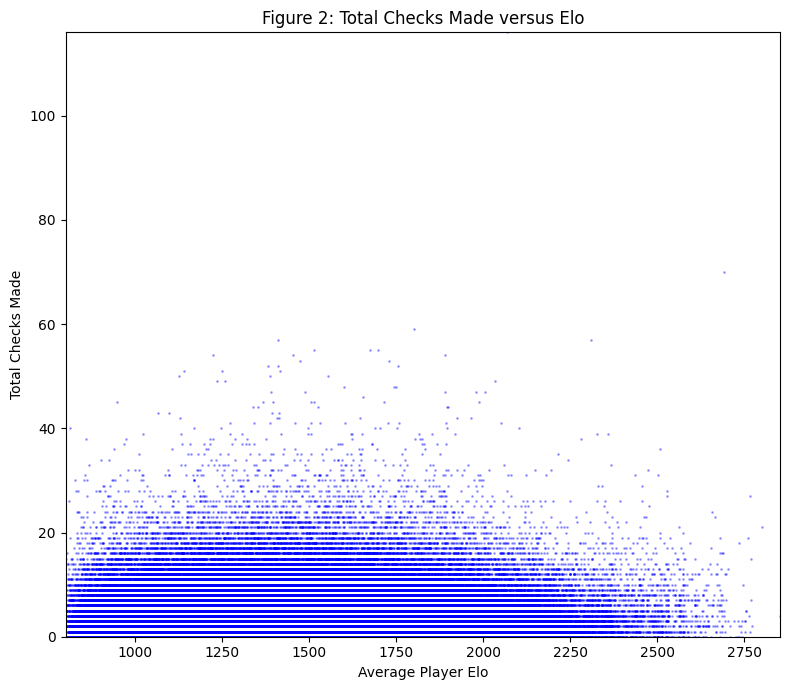

In [27]:
plt.figure(figsize=(8, 7))
plt.scatter(df_elo['average_elo'], df_elo['checks_total'], color='blue', s=1, alpha=0.3)

plt.xlabel('Average Player Elo')
plt.ylabel('Total Checks Made')
plt.title('Figure 2: Total Checks Made versus Elo')
plt.xlim([800, max(df_elo['average_elo'])])
plt.ylim([0,max(df_elo['checks_total'])])

plt.tight_layout()
plt.show()

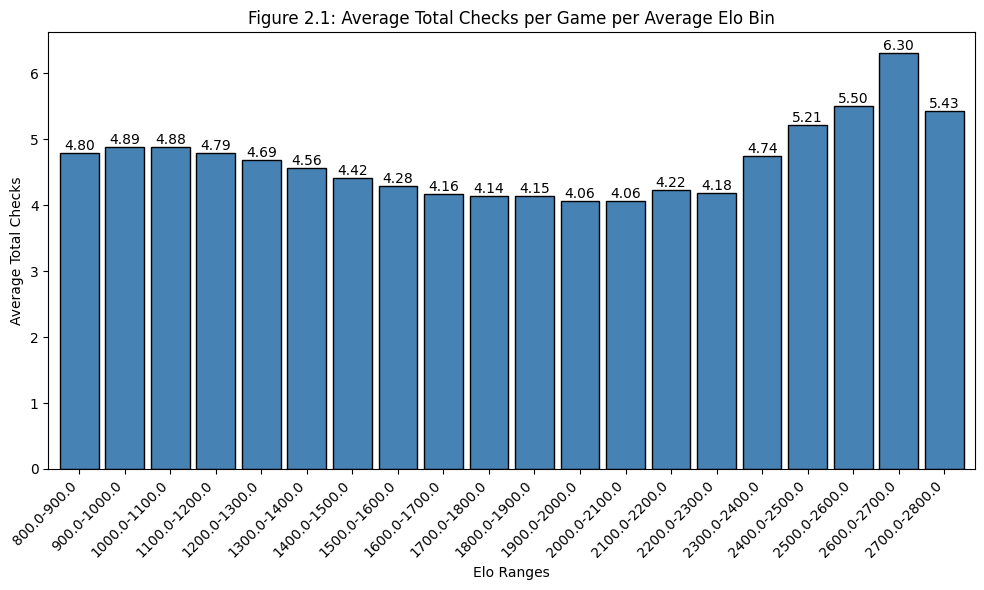

In [28]:
bin_width = 100
bins = np.arange(800, max(df_elo['average_elo'])+1, bin_width)
bin_labels = [f'{b}-{b+bin_width}' for b in bins[:-1]]

df_elo['elo_bin'] = pd.cut(df_elo['average_elo'], bins=bins, labels=bin_labels, right=False)
bin_avg_checks = df_elo.groupby('elo_bin', observed=False)['checks_total'].mean()

plt.figure(figsize=(10, 6))
bin_avg_checks.plot(kind='bar', color='steelblue', edgecolor='black', width=0.85)

plt.xlabel('Elo Ranges')
plt.ylabel('Average Total Checks')
plt.title('Figure 2.1: Average Total Checks per Game per Average Elo Bin')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(bin_avg_checks):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

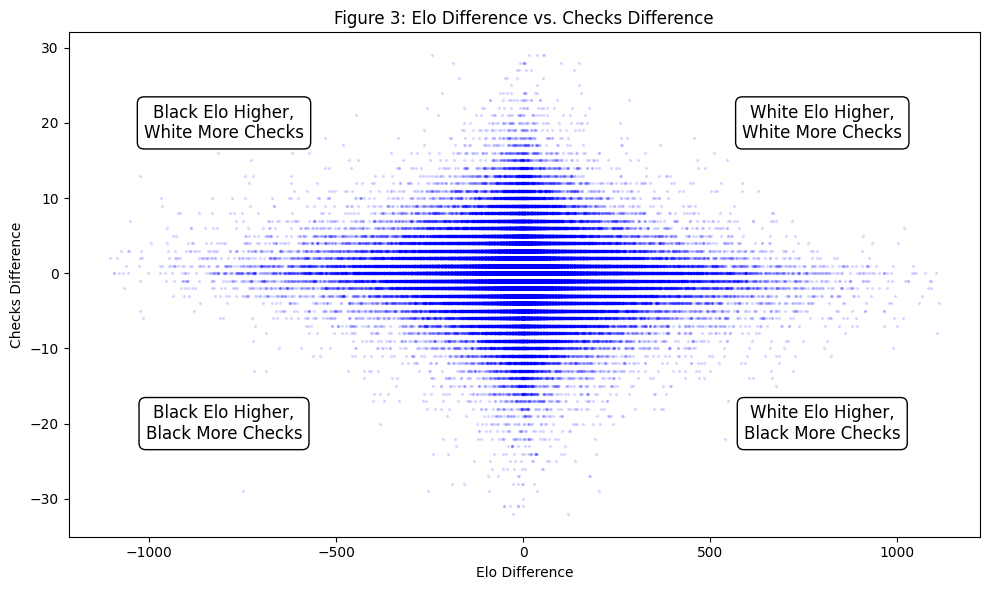

In [29]:
plt.figure(figsize=(10, 6))

elo_0_1 = np.percentile(df_elo['elo_difference'], 0.01)
elo_99_9 = np.percentile(df_elo['elo_difference'], 99.99)
checks_0_1 = np.percentile(df_elo['check_diff'], 0.01)
checks_99_9 = np.percentile(df_elo['check_diff'], 99.99)

filtered_df = df_elo[
    (df_elo['elo_difference'] >= elo_0_1) & (df_elo['elo_difference'] <= elo_99_9) &
    (df_elo['check_diff'] >= checks_0_1) & (df_elo['check_diff'] <= checks_99_9)
]

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['elo_difference'], filtered_df['check_diff'], color='blue', alpha=0.1, s=2)

plt.xlabel('Elo Difference')
plt.ylabel('Checks Difference')
plt.title('Figure 3: Elo Difference vs. Checks Difference')

plt.text( 800, 20, 'White Elo Higher,\nWhite More Checks', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
plt.text( 800,-20, 'White Elo Higher,\nBlack More Checks', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
plt.text(-800, 20, 'Black Elo Higher,\nWhite More Checks', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
plt.text(-800,-20, 'Black Elo Higher,\nBlack More Checks', color='black', ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

plt.tight_layout()
plt.show()

### Question 7.5 - Do players check more often when in a disadvantageous position?

To answer this question, we must be able to determine if a check is even possible in a given position. One of the columns in the dataset is the number of possible moves that can be made. However, because to obtain this data, I would need to write a more complex function that is independent of data analysis, I will be pursuing this in the future. It would also be nice to know what the evaluation would be after any checks are made, as this would influence whether the player actually follows that line or not.